In [ ]:
# FVCOME files are in this location 
#S:\Data\External_Models\Outputs\GLCFS\LakeHuron
#

# Introduction 

Following Code Uses PyLag, offline Particle Tracking model and FVCOM outputs that are Downloaded from the following for 2023 https://noaa-nos-ofs-pds.s3.amazonaws.com/index.html#lmhofs/netcdf
and Computes Lagrangian Particle Tracking for particles that are release at the mouth of Lake Huron's stream watersheds.

## Required imports

In [24]:
# File system and configuration management
import os
import configparser

# Data handling and processing
import numpy as np
import pandas as pd
from collections import namedtuple
from datetime import timedelta, datetime

# NetCDF data handling
from netCDF4 import Dataset
from cftime import num2pydate

# Visualization: general plotting, Cartopy, and Matplotlib utilities
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap, LogNorm
from mpl_toolkits.axes_grid1 import make_axes_locatable
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import cartopy.crs as ccrs

# FVCOM-specific visualization and utility tools
from pylag.processing.plot import FVCOMPlotter, create_figure, colourmap
from pylag.processing.utils import get_grid_bands
from pylag.grid_metrics import create_fvcom_grid_metrics_file

# Regridding, viewing, and garbage collection utilities
from pylag.regrid import regridder
from pylag.processing.ncview import Viewer
import gc


# Inputs

In [44]:
data_dir='/home/abolmaal/Data/FVCOMEDATA'.format(os.environ['HOME']) 

# Create run directory
cwd = os.getcwd()
# Create run directory
simulation_dir = '/home/abolmaal/modelling/FVCOM/Huron'.format(cwd)
try:
    os.makedirs(simulation_dir)
except FileExistsError:
    pass


# Create input sub-directory for input files
input_dir = '{}/input'.format(simulation_dir)
try:
    os.makedirs(input_dir)
except FileExistsError:
    pass


# input file to create grid metrics
fvcom_file_name = os.path.join(data_dir, 'nos.lmhofs.fields.n000.20230101.t00z.nc')

# The file listing the location of open boundary nodes

obc_file_name = '/home/abolmaal/modelling/FVCOM/Huron/input/obc.dat'


# initial position of the particles
initial_position_file = f"{input_dir}/initial_position/initial_positions_releasezone_intersection_multigroup.dat"

# config file
config_file = f"{input_dir}/config_files/Huron_Senseflux_Seasonal.cfg"


# Outputs

In [45]:
# The name of the output file containing the grid metrics
grid_metrics_file_name = f'{input_dir}/gridfile/grid_metrics_huron_senseflux_Seasonal_winter.nc'



# Create output sub-directory
output_dir = '{}/output'.format(simulation_dir)
try:
    os.makedirs(output_dir)
except FileExistsError:
    pass

# Create Figure sub-directory
fig_dir = '{}/figures'.format(simulation_dir)
try:
    os.makedirs(fig_dir)
except FileExistsError:
    pass

# output path saving the figure
fig_path_initilapositions = os.path.join(fig_dir, 'initial_positions_LakeHuron_multigrouppoint_intersection.jpeg')

# Parameters

## Figure Parameters

In [95]:
#Figure Parameters
# Create figure
font_size = 15
figsize=(26., 26.)
cmap = colourmap('h_r')
blue_shades = ['#f7fbff', '#deebf7', '#c6dbef', '#9ecae1', '#6baed6', '#4292c6', '#2171b5', '#084594']
blue_shades_reversed = blue_shades[::-1]
# Create a custom colormap
blue_cmap_reversed = LinearSegmentedColormap.from_list('custom_blue_reversed', blue_shades_reversed)


# Bathymetry 

# Read in the bathymetry
ds = Dataset(grid_metrics_file_name, 'r')
bathy = -ds.variables['h'][:]
# make a color scale of light green to blue 
GnBu = LinearSegmentedColormap.from_list('GnBu', [(0, '#f0f9e8'), (0.5, '#bae4bc'), (1, '#7bccc4')], N=256)
bathy_cmap = GnBu

ds.close()
del(ds)

# extends 
#Lake Huron extents
extents_LH = np.array([275, 277.69, 43, 46.3], dtype=float)
extents_ausable = np.array([276.5, 276.8, 45, 45.5], dtype=float)
#
batch_size = 50


# Main Functions

## 1-Create Grid metrics

In [35]:
# Generate the file
create_fvcom_grid_metrics_file(fvcom_file_name, obc_file_name = obc_file_name,
                               grid_metrics_file_name=grid_metrics_file_name)

Creating FVCOM grid metrics file /home/abolmaal/modelling/FVCOM/Huron/input/gridfile/grid_metrics_huron_senseflux_Seasonal_winter.nc
INFO - detected longitudes greater than 180.0 in variable lon. Assuming longitude limits are in the range 0 - 360. Correcting these to be in the range -180 to 180.
INFO - detected longitudes greater than 180.0 in variable lonc. Assuming longitude limits are in the range 0 - 360. Correcting these to be in the range -180 to 180.

Calculating element areas ... done
Grid has 51110 nodes on the open boundary


## 2-Creating Run configuration

In [87]:
# config file
#config_file = f"{input_dir}/config_files/Huron_Senseflux_Seasonal.cfg"
config_file_name = '/home/abolmaal/modelling/FVCOM/Huron/config_files/Huron_Senseflux_Seasonal.cfg'


cf = configparser.ConfigParser()
cf.read(config_file_name)

# Start time
print('Start time: {}'.format(cf.get('SIMULATION', 'start_datetime')))

# End time
print('End time: {}'.format(cf.get('SIMULATION', 'end_datetime')))

# Specify that this is a forward tracking experiment
print('Time direction: {}'.format(cf.get('SIMULATION', 'time_direction')))

# We will do a single run, rather than an ensemble run
print('Number of particle releases: {}'.format(cf.get('SIMULATION', 'number_of_particle_releases')))

# Use depth restoring, and restore particle depths to the ocean surface
print('Use depth restoring: {}'.format(cf.get('SIMULATION', 'depth_restoring')))
print('Restore particles to a depth of: {} m'.format(cf.get('SIMULATION', 'fixed_depth')))

# Specify that we are working with FVCOM in cartesian coordinates0
print('Model name: {}'.format(cf.get('OCEAN_DATA', 'name')))
print('Coordinate system: {}'.format(cf.get('SIMULATION', 'coordinate_system')))

# Set the location of the grid metrics and input files
print('Data directory: {}'.format(cf.get('OCEAN_DATA', 'data_dir')))
print('Path to grid metrics file: {}'.format(cf.get('OCEAN_DATA', 'grid_metrics_file')))
print('File name stem of input files: {}'.format(cf.get('OCEAN_DATA', 'data_file_stem')))
      
# Do an advection only run using a RK$ intergration scheme 
print('Numerical method: {}'.format(cf.get('NUMERICS', 'num_method')))
print('Iterative method: {}'.format(cf.get('NUMERICS', 'iterative_method')))

Start time: 2023-05-01  23:00:00
End time: 2023-06-28  18:00:00
Time direction: forward
Number of particle releases: 1
Use depth restoring: True
Restore particles to a depth of: 0.0 m
Model name: FVCOM
Coordinate system: geographic
Data directory: /home/abolmaal/Data/FVCOMEDATA
Path to grid metrics file: /home/abolmaal/modelling/FVCOM/Huron/input/gridfile/grid_metrics_huron_senseflux_Seasonal_winter.nc
File name stem of input files: nos.lmhofs.fields.n000.
Numerical method: standard
Iterative method: Adv_RK4_3D


## 3-Setting Mortality

If you use the following config file huron_senseflux_20230103_Seasonal_mortality.cfg, you don't need to run section 5. it is here for demonstration and showing how mortality works.

In [6]:
# Imports
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
from configparser import ConfigParser

import pylag.random as random
from pylag.data_reader import DataReader
from pylag.particle_cpp_wrapper import ParticleSmartPtr
from pylag.mortality import get_mortality_calculator
from pylag.processing.plot import create_figure

# Ensure inline plotting
%matplotlib inline

# Parameters
seconds_per_day = 86400.

# Seed the random number generator
random.seed(10)

# Create the config
#cf.add_section('NUMERICS')
cf.add_section('BIO_MODEL')
cf.add_section('FIXED_TIME_MORTALITY_CALCULATOR')
cf.add_section('PROBABILISTIC_MORTALITY_CALCULATOR')
# We need a data reader to pass to the mortality calculator. It
# can be used to draw out environmental variables (e.g. temperature)
# that affect mortality. In both cases below, it isn't used, so we
# use the base class.
data_reader = DataReader()

# Set time stepping params
n_particles = 1000
simulation_duration_in_days = 30.0
time_step = 100
time_end = simulation_duration_in_days * seconds_per_day
times = np.arange(0.0, time_end, time_step)

In [7]:
 #Helper function in which the model is run and mortality computed
def run(config, n_particles=1000):
    """ Run the model to compute mortality through time """

    # Create the mortality calculator
    mortality_calculator = get_mortality_calculator(config)

    # Create the living particle seed
    particle_set = []
    for i in range(n_particles):
        # Instantiate a new particle
        particle = ParticleSmartPtr(age=0.0, is_alive=True)

        # Initialise particle mortality parameters
        mortality_calculator.set_initial_particle_properties_wrapper(particle)

        # Append it to the particle set
        particle_set.append(particle)

    # Store the number of living particles in a list
    n_alive_arr = []

    # Run the model
    n_alive = n_particles
    for t in times:
        n_alive_arr.append(n_alive)

        n_deaths = 0
        for particle in particle_set:
            if particle.is_alive:
                mortality_calculator.apply_wrapper(data_reader, t, particle)
                if particle.is_alive == False:
                    n_deaths += 1
            particle.set_age(t)

        n_alive -= n_deaths

    return n_alive_arr

## 4-FixedTimeMortalityCalculater

In [8]:
# Specify a fixed time mortality calculator
cf.set('BIO_MODEL', 'mortality_calculator', 'fixed_time')

# 1) Fixed time scenario
# Sharp_2021 suggerst 10 days fpr N uptake in coastal wetlands
age_of_death_in_days = 10.
cf.set('FIXED_TIME_MORTALITY_CALCULATOR', 'initialisation_method', 'common_value')
cf.set('FIXED_TIME_MORTALITY_CALCULATOR', 'common_value', str(age_of_death_in_days))
n_alive_common_value = run(cf)

In [9]:
# 2) Uniform Random 
minimum_bound = 8.
maximum_bound = 12.
cf.set('FIXED_TIME_MORTALITY_CALCULATOR', 'initialisation_method', 'uniform_random')
cf.set('FIXED_TIME_MORTALITY_CALCULATOR', 'minimum_bound', str(minimum_bound))
cf.set('FIXED_TIME_MORTALITY_CALCULATOR', 'maximum_bound', str(maximum_bound))
n_alive_uniform_random = run(cf)

In [10]:
# 2) Gaussian random
mean = 10.
standard_deviation = 1.
cf.set('FIXED_TIME_MORTALITY_CALCULATOR', 'initialisation_method', 'gaussian_random')
cf.set('FIXED_TIME_MORTALITY_CALCULATOR', 'mean', str(mean))
cf.set('FIXED_TIME_MORTALITY_CALCULATOR', 'standard_deviation', str(standard_deviation))
n_alive_gaussian_random = run(cf)
# Set the bio time step
cf.set('NUMERICS', 'time_step_bio', str(time_step))

In [ ]:
# Plot
font_size = 10
fig, ax = create_figure(figure_size=(20, 20), font_size=font_size)
plt.plot(times/seconds_per_day, n_alive_common_value, 'b', label='common_value')
plt.plot(times/seconds_per_day, n_alive_uniform_random, 'r', label='uniform_random')
plt.plot(times/seconds_per_day, n_alive_gaussian_random, 'g', label='gaussian_random')
# Set the bio time step
plt.ylabel('Living individuals (-)', fontsize=font_size)
plt.xlabel('Time (d)', fontsize=font_size)

# Add legend
plt.legend()

## 5-ProabilisticMortalityCalculator

The mortality calculator kills particles at a rate 
, where 
 is a fixed mortality rate which is set in the run configuraiton file and 
 is the model time step for biological processes. The model computes a uniform random deviate in the range (0, 1). If the number is less than the computed death rate, the particle is killed. Below, we create a population of 
 individuals. We apply a death rate of 
 per day and use a time step of 
 seconds. The model is run forward for 
 days and the number of living individuals plotted as a function of time. The result is compared with a simple analytical solution of exponential decay

In [82]:

# Specify a probabilistic mortality calculator
cf.set('BIO_MODEL', 'mortality_calculator', 'probabilistic')

# Set the death rate - currently the same for all particles.
death_rate_per_day = 0.1
cf.set('PROBABILISTIC_MORTALITY_CALCULATOR', 'death_rate_per_day', str(death_rate_per_day))

# Set the bio time step
cf.set('NUMERICS', 'bio_time_step', str(time_step))

# Number of particles
n_particles = 1000

# Run the model
n_alive_numeric = run(cf, n_particles=n_particles)

# Compute the equivalent analytical solution
death_rate_per_second = death_rate_per_day / seconds_per_day
n_alive_analytic = n_particles * np.exp(-death_rate_per_second * times)

# Plot
font_size = 10
fig, ax = create_figure(figure_size=(20, 20), font_size=font_size)
plt.plot(times/seconds_per_day, n_alive_numeric, 'b', label='numeric')
plt.ylabel('Living individuals (-)', fontsize=font_size)
plt.xlabel('Time (d)', fontsize=font_size)

# Add equivalent analytical solution
plt.plot(times/seconds_per_day, n_alive_analytic, 'r', label='analytic')

# Add legend
plt.legend()

NoSectionError: No section: 'BIO_MODEL'

# 6-Run the model 

In [88]:
cf.set('OCEAN_DATA', 'data_dir', data_dir)
cf.set('OCEAN_DATA', 'grid_metrics_file', grid_metrics_file_name)
# Directory where the simulation outputs will be saved
out_dir = f"{simulation_dir}/output"
cf.set('GENERAL', 'out_dir', out_dir)

# Save a copy in the simulation directory
with open(f"{simulation_dir}/pylag.cfg", 'w') as config:
    cf.write(config)

In [89]:
# Change to the run directory
os.chdir(f"{simulation_dir}")

# Run the model
!{"python -m pylag.main -c pylag.cfg"}

# Return to the cwd
os.chdir(cwd)



Starting ensemble member 1 ...
Progress:
100% |###########################################|


## 7-Plotting the Data

### Plot Initial Positions

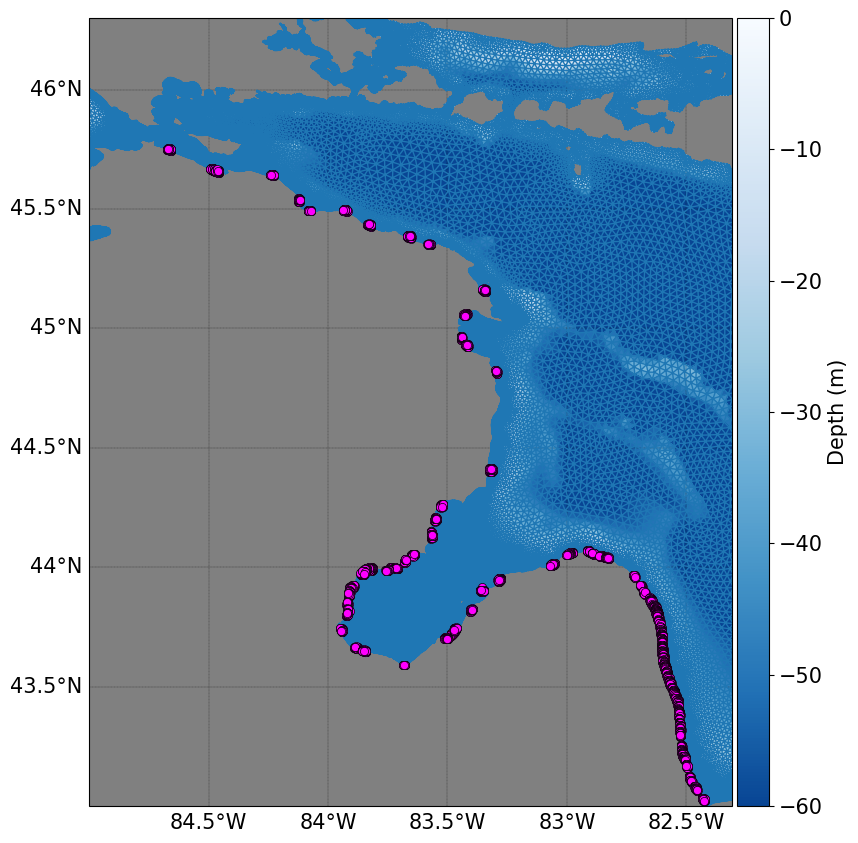

In [100]:
# Read the initial position file into a pandas DataFrame and skip the first line
df = pd.read_csv(initial_position_file, sep = ' ',skiprows=1)
group_id = df.iloc[:,0]
lons = df.iloc[:,1] 
lats= df.iloc[:,2]

# Create figure

fig, ax = create_figure(figure_size=figsize, projection=ccrs.PlateCarree(),
                      font_size=font_size, bg_color='gray')

# Configure plotter
plotter = FVCOMPlotter(grid_metrics_file_name,
                       geographic_coords=True,
                       font_size=font_size)

# Plot bathymetry
ax, plot = plotter.plot_field(ax, bathy, extents=extents, add_colour_bar=True, cb_label='Depth (m)',
                              vmin=-60., vmax=0., cmap=blue_cmap_reversed)

# Overlay grid
plotter.draw_grid(ax, linewidth=1.0)

# Plot particle initial positions
scatter = plotter.scatter(ax, lons, lats, s=35, color='fuchsia', edgecolors='black', linewidth=0.5, zorder=10)

# save the initial positions figure in the figure directory

plt.savefig(fig_path_initilapositions, dpi=300)

### Plotting PyLag results

In [92]:

# Create a list of file names

for file_name in sorted(filter(lambda x: x.endswith("nc"), os.listdir(output_dir)), key=lambda x: int(x.split(".")[0].split("__")[1])):
    sample_name = file_name
    file_name = os.path.join(output_dir, file_name)
    time_of_flight = timedelta(hours=24)
   
    # Set the extents
    extents = extents_LH
    
    # Create figure
    fig, ax = create_figure(figure_size=figsize, projection=ccrs.PlateCarree(), font_size=font_size, bg_color='gray')
    
    # Assuming grid_metrics_file_name, bathy, and cmap are defined elsewhere
    plotter = FVCOMPlotter(grid_metrics_file_name, geographic_coords=True, font_size=font_size)
    plotter.plot_field(ax, bathy, extents=extents, add_colour_bar=True, cb_label='Depth (m)', vmin=-60., vmax=0., cmap=cmap)
    
    viewer = Viewer(file_name, time_rounding=25200)
    date = viewer.date[0] + time_of_flight
    if date in viewer.date.tolist():
        time_index = viewer.date.tolist().index(date)
    else:
        print(f"Date {date} not found in viewer.date")
        continue
    # Convert positions into lons/lats
    lons, lats = [viewer('longitude')[time_index, :].squeeze(), viewer('latitude')[time_index, :].squeeze()]
    
    # Plot particle final positions
    ax, scatter = plotter.scatter(ax, lons, lats, s=8, color='#e50000', edgecolors='black')
    
    lons_paths, lats_paths = (viewer('longitude')[:time_index + 1, :], viewer('latitude')[:time_index + 1, :])
    
    # Convert all pathline coordinates into lons/lats
    ax, lines = plotter.plot_lines(ax, lons_paths, lats_paths, linewidth=0.5, alpha=1, color='#0504aa')
    
    output_file = os.path.join(fig_dir, f"{sample_name.split('.')[0]}.png")
    plt.savefig(output_file, dpi=50)
    plt.close(fig)
    gc.collect()

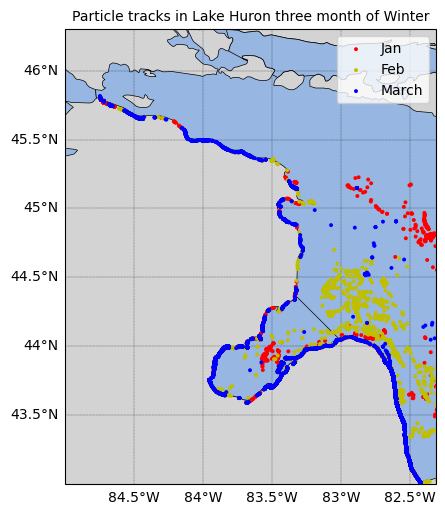

In [91]:
import numpy as np
import matplotlib
import cartopy.crs as ccrs
import cartopy.feature as cfeature

from pylag.processing.ncview import Viewer
from pylag.processing.plot import create_figure, ArakawaAPlotter


%matplotlib inline


# Plot options
font_size = 10

# Create figure
fig, ax = create_figure(figure_size=(15., 15.), projection=ccrs.PlateCarree(),
                        font_size=font_size, bg_color='white')

# Configure plotter
plotter = FVCOMPlotter(grid_metrics_file_name,
                          font_size=font_size)

extents = extents_LH

# Add tracks from the ocean only run
# ----------------------------------
# PyLag file name
file_name = f'{output_dir}/Fvcom_Huron_23_Jan__1.nc'

# Dataset holding particle positions
viewer = Viewer(file_name, time_rounding=60)

# Plot final positions
plotter.scatter(ax,
                viewer('longitude')[-1, :].squeeze(),
                viewer('latitude')[-1, :].squeeze(),
                s=8, color='r', edgecolors='none',
                configure=True,
                draw_coastlines=True,
                tick_inc=True,
                extents=extents,label= 'Jan')

# Add high resolution land
ax.add_feature(cfeature.LAND, facecolor='lightgrey')
ax.add_feature(cfeature.COASTLINE, edgecolor='black', linewidth=0.5)
ax.add_feature(cfeature.BORDERS, edgecolor='black', linewidth=0.5)
ax.add_feature(cfeature.LAKES, edgecolor='black', linewidth=0.5)

# # Plot paths
# _ = plotter.plot_lines(ax,
#                        viewer('longitude')[:, :].squeeze(),
#                        viewer('latitude')[:, :].squeeze(),
#                        linewidth=1., alpha=1, color='r')


# Add tracks from the ocean + stokes drift run
# --------------------------------------------
# PyLag file name
file_name = f'{output_dir}/Fvcom_Huron_23_Feb__2.nc'

# Dataset holding particle positions
viewer = Viewer(file_name, time_rounding=60)

# Plot final positions
plotter.scatter(ax,
                viewer('longitude')[-1, :].squeeze(),
                viewer('latitude')[-1, :].squeeze(),
                s=8, color='y', edgecolors='none', label = 'Feb')

# # Plot paths
# _ = plotter.plot_lines(ax,
#                        viewer('longitude')[:, :].squeeze(),
#                        viewer('latitude')[:, :].squeeze(),
#                        linewidth=1., alpha=1, color='y')


# Add tracks from the ocean + leeway run
# --------------------------------------
# PyLag file name
file_name = f'{output_dir}/Fvcom_Huron_23_Mar__3.nc'

# Dataset holding particle positions
viewer = Viewer(file_name, time_rounding=60)

# Plot final positions
plotter.scatter(ax,
                viewer('longitude')[-1, :].squeeze(),
                viewer('latitude')[-1, :].squeeze(),
                s=8, color='b', edgecolors='none', label = 'March')
plt.legend()
plt.title('Particle tracks in Lake Huron three month of Winter', fontsize=font_size)
# Save the figure
output_file = os.path.join(fig_dir, 'tracks_LakeHuron_JanFebMarch_2.jpeg')
plt.savefig(output_file, dpi=300)

# Plot paths
# _ = plotter.plot_lines(ax,
#                        viewer('longitude')[:, :].squeeze(),
#                        viewer('latitude')[:, :].squeeze(),
#                        linewidth=1., alpha=1, color='b')